In [263]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from collections import Counter
import re
from datasets import load_dataset
from classes import SentimentDataset
from collections import Counter
from tqdm import tqdm
from nltk.tokenize import word_tokenize, RegexpTokenizer
nltk.download('punkt')
from stopwordsiso import stopwords


[nltk_data] Downloading package punkt to /home/vuong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [264]:
nltk.data.find('tokenizers/punkt')  # Kiểm tra xem đã có chưa
nltk.download('punkt', force=True)
nltk.download('punkt_tab')
vietnamese_stopwords = stopwords(['vi'])

[nltk_data] Downloading package punkt to /home/vuong/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/vuong/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [265]:
# data = pd.read_csv('sentiment.csv').dropna()
# data
from datasets import load_dataset
import dataset

ds = load_dataset("uitnlp/vietnamese_students_feedback")
# Chuyển tập train từ Hugging Face dataset sang pandas DataFrame
data= ds['train'].to_pandas()
data = data.rename(columns={'sentence': 'text', 'sentiment': 'label'})

val_df = ds['validation'].to_pandas()
test_df = ds['test'].to_pandas()

In [266]:
data

,text,label,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0
...,...,...,...
11421,chỉ vì môn game mà em học hai lần mà không qua...,0,1
11422,em cảm ơn cô nhiều .,2,0
11423,giao bài tập quá nhiều .,0,0
11424,"giáo viên dạy dễ hiểu , nhiệt tình .",2,0


In [267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11426 non-null  object
 1   label   11426 non-null  int64 
 2   topic   11426 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 267.9+ KB


In [268]:
data.isnull().sum()

text     0
label    0
topic    0
dtype: int64

In [269]:
duplicates = data[data.duplicated(subset='text', keep=False)]
print(duplicates)

                                                    text  label  topic
11293  thầy dạy hay , tuy nhiên còn nhiều chỗ chưa th...      2      0
11417  thầy dạy hay , tuy nhiên còn nhiều chỗ chưa th...      0      0


In [270]:
data = data.drop_duplicates(subset=['text'], keep='first')

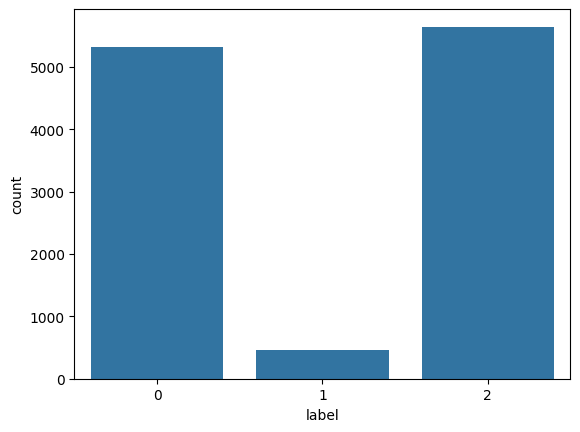

In [271]:
import seaborn as sb
x = sb.countplot(x='label',data=data)

In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11425 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11425 non-null  object
 1   label   11425 non-null  int64 
 2   topic   11425 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 357.0+ KB


In [273]:
import re
# Sử dụng .loc để thay đổi giá trị trong DataFrame gốc
data["text"] = data["text"].str.strip().str.replace("\n"," ")

/tmp/ipykernel_8694/690375164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["text"] = data["text"].str.strip().str.replace("\n"," ")


In [274]:
texts = [re.sub(r"[^\w\s]", "", t.lower()) for t in data['text']]
texts = [' '.join(t.strip().split()) for t in texts]

tokenizer = RegexpTokenizer(r'\w+')
tokens = [word_tokenize(t) for t in tqdm(texts)]
tokens = [["".join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]

texts = [" ".join(t) for t in tokens]
labels = data['label'].tolist()
# labels = data['label'].map({'Positive': 0, 'Negative': 1, 'Neutral': 2}).tolist()

100%|██████████████████████████████████| 11425/11425 [00:00<00:00, 40088.38it/s]


In [275]:
# tokenized_texts = [word_tokenize(t) for t in texts]

tokenized_texts = [
    [word for word in word_tokenize(t) if word not in vietnamese_stopwords]
    for t in tqdm(texts)
]

100%|███████████████████████████████████| 11425/11425 [00:01<00:00, 8979.81it/s]


Max length: 86
Mean length: 8.410678336980306
Median length: 7.0
90th percentile: 15.0
95th percentile: 19.0
99th percentile: 29.0


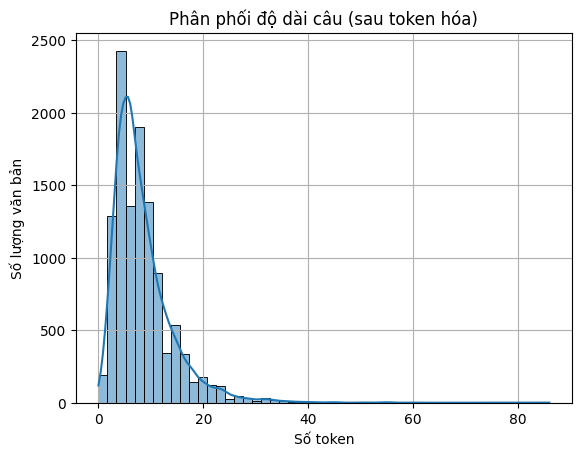

In [276]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
lengths = [len(seq) for seq in tokenized_texts]

print("Max length:", max(lengths))
print("Mean length:", np.mean(lengths))
print("Median length:", np.median(lengths))
print("90th percentile:", np.percentile(lengths, 90))
print("95th percentile:", np.percentile(lengths, 95))
print("99th percentile:", np.percentile(lengths, 99))

sns.histplot(lengths, bins=50, kde=True)
plt.title("Phân phối độ dài câu (sau token hóa)")
plt.xlabel("Số token")
plt.ylabel("Số lượng văn bản")
plt.grid(True)
plt.show()

In [277]:

all_words = [w for txt in tokenized_texts for w in txt]
most_common = Counter(all_words).most_common(4998)

vocab = {'<PAD>': 0, '<UNK>': 1}
for i, (w, _) in enumerate(most_common, 2):
    vocab[w] = i

def to_indices(tokens, max_len):
    idxs = [vocab.get(t, 1) for t in tokens][:max_len]
    return idxs + [0] * (max_len - len(idxs))

max_len_text = 20
text_indices = [to_indices(t, max_len_text) for t in tokenized_texts]

train_texts, test_texts, train_labels, test_labels = train_test_split(text_indices, labels, test_size=0.1, random_state=42)

In [278]:
train_dataset = SentimentDataset(train_texts, train_labels)
test_dataset = SentimentDataset(test_texts, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [280]:
data_to_save = {
    'train_loader': train_loader,
    'test_loader': test_loader,
    'batch_size': 32,
    'vocab': vocab,
    'vocab_size': len(vocab)
}
save_path = 'sentiment_data_loader.pth'
torch.save(data_to_save, save_path)